**Description:**
  * Using the `LinearRegressor` class in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
  * Evaluating the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Improving the accuracy of a model by tuning its hyperparameters

In [1]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12689,-121.8,36.9,46.0,947.0,257.0,1120.0,264.0,3.4,160.7
807,-117.1,33.1,31.0,2055.0,473.0,1326.0,427.0,3.1,139.9
5048,-118.1,34.1,52.0,2907.0,317.0,956.0,279.0,15.0,500.0
11615,-121.3,37.8,10.0,9205.0,1774.0,5935.0,1673.0,3.6,119.4
15259,-122.3,38.3,23.0,1398.0,388.0,1112.0,406.0,2.2,140.2
...,...,...,...,...,...,...,...,...,...
16901,-124.0,40.6,32.0,1878.0,340.0,937.0,353.0,3.4,95.2
9518,-119.3,35.9,20.0,1934.0,377.0,1341.0,336.0,2.1,62.6
2587,-117.7,33.5,10.0,3484.0,582.0,1469.0,556.0,5.4,402.2
12795,-121.8,37.2,18.0,3179.0,526.0,1663.0,507.0,5.9,265.8


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [5]:
my_feature = california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [6]:
targets = california_housing_dataframe["median_house_value"]

In [7]:
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [9]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [10]:
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [11]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value
print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [12]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [13]:
sample = california_housing_dataframe.sample(n=300)

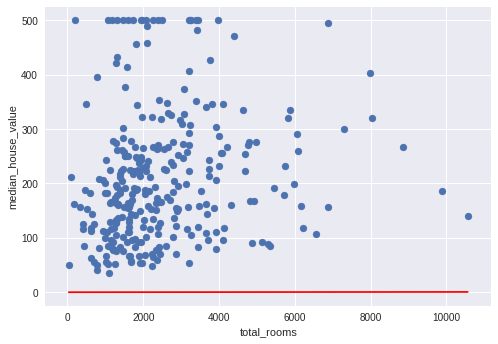

In [14]:
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias
plt.plot([x_0, x_1], [y_0, y_1], c='r')
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")
plt.scatter(sample["total_rooms"], sample["median_house_value"])
plt.show()

In [15]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  periods = 10
  steps_per_period = steps / periods
  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])  
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    root_mean_squared_errors.append(root_mean_squared_error)
    y_extents = np.array([0, sample[my_label].max()])    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                           sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())
  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.85
  period 02 : 204.44
  period 03 : 195.33
  period 04 : 187.86
  period 05 : 181.62
  period 06 : 176.56
  period 07 : 172.62
  period 08 : 170.01
  period 09 : 168.08
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,112.1,207.3
std,92.4,116.0
min,0.1,15.0
25%,62.0,119.4
50%,90.2,180.4
75%,133.6,265.0
max,1608.5,500.0


Final RMSE (on training data): 168.08


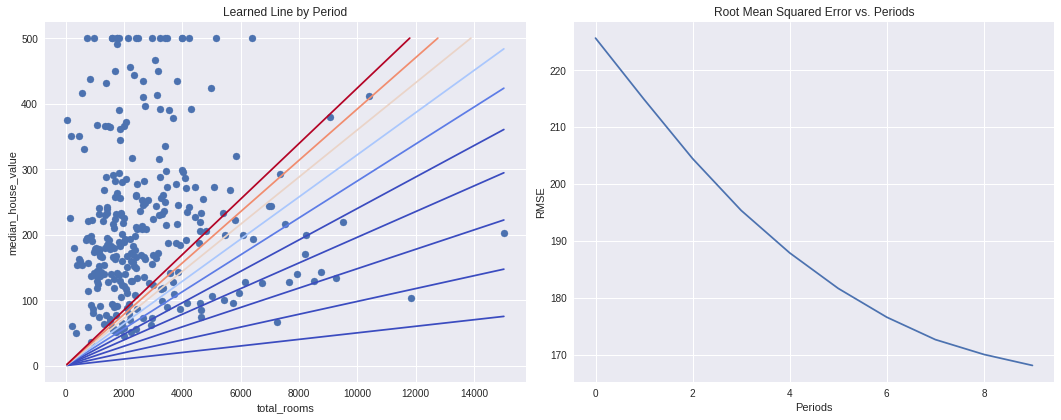

In [16]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 204.67
  period 03 : 196.59
  period 04 : 189.52
  period 05 : 184.79
  period 06 : 181.10
  period 07 : 178.49
  period 08 : 176.84
  period 09 : 176.16
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,117.2,207.3
std,94.1,116.0
min,0.2,15.0
25%,64.8,119.4
50%,95.7,180.4
75%,141.1,265.0
max,2926.0,500.0


Final RMSE (on training data): 176.16


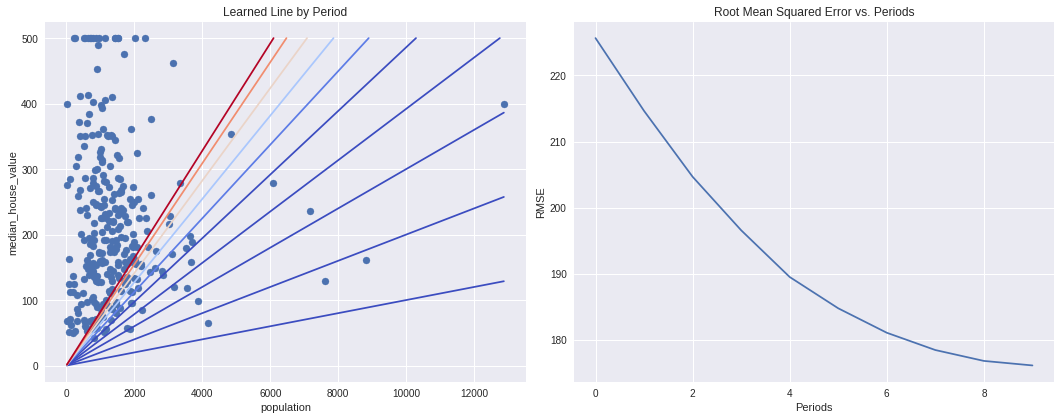

In [17]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)